# Preliminary support for predictive coding  

If inhibitory interneurons subtract a prediction of ganglion firing, we should expect higher correlations between the ganglion cells and connected inhibitory interneurons if we were able to silence inhibitory communication to the ganglion cells (but not alter the inhibitory membrane potential).  

We can essentially do this with intracellular record & playback experiments. This notebook will help provide some quantitative intuition for what direction correlations should change, as a function of stimulus statistics.

In [2]:
from __future__ import division
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import sem, pearsonr
from image_processing_functions import load_images
from lnl_model_functions import gaussian
from scipy.signal import convolve2d
from scipy.ndimage.filters import convolve1d
from scipy.interpolate import interp1d
import os
import pyret # note that this changes matplotlibrc settings

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
from matplotlib.pyplot import *

# note that nonposx(y) for log plots will no longer work with this package
import mpld3
#mpld3.enable_notebook()

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Generate stimulus  

All of our receptive fields are 1d in space, so let the stimulus be space x time.

In [3]:
stimulus_type = 'white-noise'
num_frames = 1000
num_pixels = 500

if stimulus_type == 'natural-scenes':
    im_dir = os.path.expanduser('~/Documents/Natural_Images/RawData/cd13A') # flood plain, water, horizon
    patch_size = None
    num_images = 100
    stimulus = load_images(im_dir, num_images, patch_size, square=True, normalize='divisive')

elif stimulus_type == 'white-noise':
    num_checkers = 25
    if num_pixels % num_checkers != 0:
        raise Exception('Number of pixels not divisible by number of checkers.')
    else:
        pixels_per_checker = int(num_pixels/num_checkers)
    checkers = np.random.randn(num_checkers, num_frames)
    stimulus = np.zeros((num_pixels, num_frames))
    for idc, checker in enumerate(checkers):
        stimulus[pixels_per_checker*idc:pixels_per_checker*(idc+1)] = checker

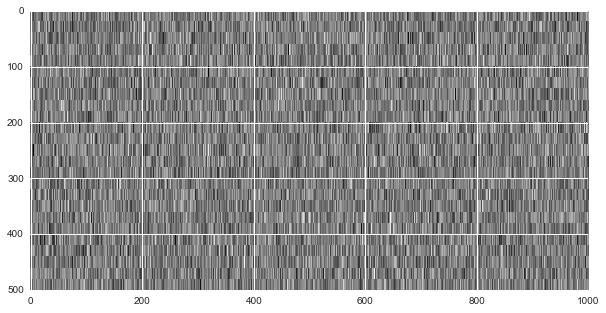

In [4]:
distance_per_pixel = 0.027 # mm (actually, it's 0.022mm for bipolar cell and 0.027mm for amacrine cell)
time_per_frame = 0.01 # seconds, or 10 ms
imshow(stimulus) #, extent=[0,time_per_frame*stimulus.shape[1],0,distance_per_pixel*stimulus.shape[0]])

# Create model  

Model should have multiple excitatory channels where a subset of the excitation flows into an inhibitory pathway. A subset of the excitation and inhibition should then combine to give a thresholded model prediction (ganglion response).  

To make this somewhat realistic, I'll use real bipolar and amacrine cell receptive fields, and ganglion cells will be a linear combination of them.

#### Get bipolar and amacrine receptive fields

In [5]:
def get_bipolar_rfs():
    # spatialDelta = 0.022 # mm
    data_path  = os.path.expanduser('~/Documents/Stanford/00 Baccus Lab/Surround size project/david_receptive_fields')
    file_name1 = data_path + '/B1.txt'
    file_name2 = data_path + '/B2.txt'
    data_b1    = np.loadtxt(file_name1, delimiter="\t") # 50 time x 100 space
    data_b2    = np.loadtxt(file_name2, delimiter="\t") # 50 time x 100 space
    data_b     = [data_b1.T, data_b2.T] # space x time
    return data_b

def get_amacrine_rfs():
    # spatialDelta = 0.027 # mm
    data_path = os.path.expanduser('~/Documents/Stanford/00 Baccus Lab/Surround size project/david_receptive_fields')
    file_name = data_path + '/H1A2.txt'
    data_ha   = np.loadtxt(file_name, delimiter="\t")
    data_ha   = data_ha.reshape((3,50,80))
    data_a    = data_ha[1:, :, :] # first cell in this file is a horizontal cell
    rfs       = []
    for a in data_a:
        rfs.append(a.T)
    return rfs
    

#### Construct model using bipolar and amacrine receptive fields

In [6]:
def ganglion_population_response(stimulus, num_ganglion_cells=10, threshold=1, inhibitory_gain=1., 
                                 poisson_discount=3., every_n_ama=10, plot_amacrine_rfs=False,
                                 plot_bipolar_rfs=False):
    '''
    Stimulus should be space x time.
    Threshold should be in standard deviations.
    Returns (amacrine membrane potentials, response ganglion population x time)
    '''
    if len(stimulus.shape) != 2:
        raise Exception('Stimulus needs to be 2 dimensional.')
    
    # loading receptive fields as (space in degrees, sensitivity) tuples
    # just get one of each for now
    bipolar_rf = get_bipolar_rfs()[0]
    amacrine_rf = get_amacrine_rfs()[0]

    # how many bipolar cells and how many amacrine cells are connected to the ganglion cells,
    # and with what strength?
    bip_const = 1.
    ama_const = 78./22.
    bip_projection = [np.exp(-abs(s)/bip_const) for s in np.linspace(-22,22,bipolar_rf.shape[1])]
    ama_projection = [np.exp(-abs(s)/ama_const) for s in np.linspace(-22,22,amacrine_rf.shape[1])]
    bip_pop = convolve1d(bipolar_rf, bip_projection, axis=0)
    ama_pop = convolve1d(amacrine_rf, ama_projection, axis=0)
    
    if plot_amacrine_rfs:
        subplot(1,2,1)
        imshow(ama_pop)
        title('Population Amacrine RF', fontsize=18)
        subplot(1,2,2)
        imshow(amacrine_rf)
        title('Individual Amacrine RF', fontsize=18)
        
    if plot_bipolar_rfs:
        subplot(1,2,1)
        imshow(bip_pop)
        title('Population Bipolar RF', fontsize=18)
        subplot(1,2,2)
        imshow(bipolar_rf)
        title('Individual Bipolar RF', fontsize=18)
    
    # store the individual amacrine membrane potentials
    amacrines = convolve2d(stimulus, amacrine_rf, mode='same')
    
    # get the linear response of bipolar and amacrine cells
    excitation = convolve2d(stimulus, bip_pop, mode='same')
    inhibition = convolve2d(stimulus, ama_pop, mode='same')
    
    # compute ganglion response    
    ganglion_response = excitation - inhibitory_gain * inhibition
    
    # threshold response
    divide_by = ganglion_response.shape[0]/num_ganglion_cells
    ganglion_response = ganglion_response[::divide_by,:]
    thresholded = np.where(ganglion_response > threshold * np.std(ganglion_response), 
                           ganglion_response/np.max(ganglion_response), 0)
    
    # convert thresholded response to poisson spiking
    spiking = np.random.poisson(thresholded/poisson_discount)
    return ((amacrines/np.max(abs(amacrines)))[::every_n_ama], np.where(spiking > 1, 1, 0))

In [7]:
inhibition, ganglions = ganglion_population_response(stimulus, threshold=.2, poisson_discount=1.)

/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:54: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [8]:
inhibition.shape

(50, 1000)

In [9]:
ganglions.shape

(10, 1000)

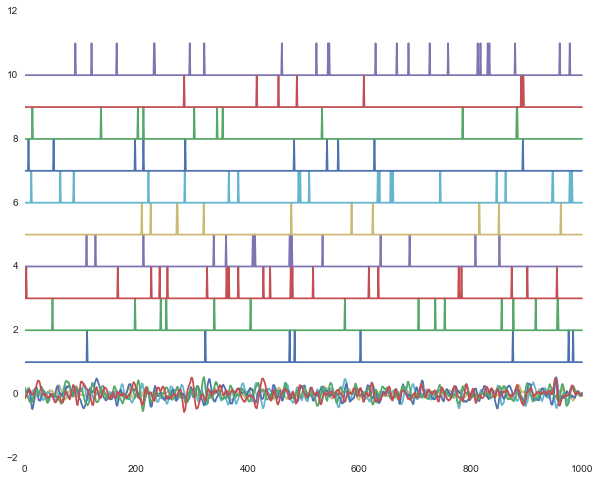

In [10]:
# if we limit ourselves to every 10th, the inhibitory cells should line up with the ganglion cells
p = plot(ganglions.T + np.arange(10) + 1)
p = plot(inhibition[::10,:].T)

In [11]:
control_corrs = {}
for idg,g in enumerate(ganglions):
    for i in inhibition:
        if idg in control_corrs.keys():
            control_corrs[idg].append(pearsonr(g,i)[0])
        else:
            control_corrs[idg] = [pearsonr(g,i)[0]]

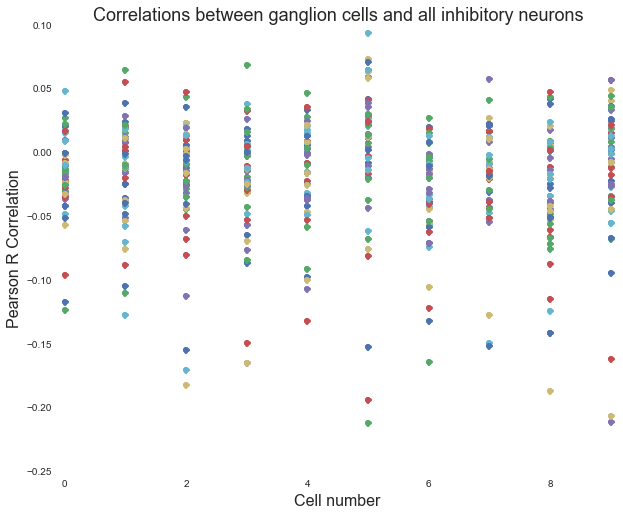

In [12]:
p = plot(control_corrs.values(), 'o')
xlim([-0.1, 9.1])
title('Correlations between ganglion cells and all inhibitory neurons', fontsize=18)
xlabel('Cell number', fontsize=16)
ylabel('Pearson R Correlation', fontsize=16)

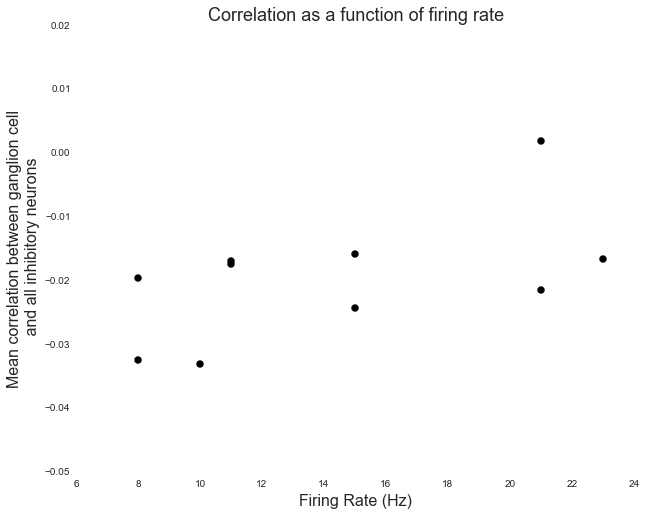

In [13]:
scatter(np.sum(ganglions, axis=1), np.mean(control_corrs.values(), axis=1), s=50, c='k')
title('Correlation as a function of firing rate', fontsize=18)
xlabel('Firing Rate (Hz)', fontsize=16)
ylabel('Mean correlation between ganglion cell \n and all inhibitory neurons', fontsize=16)

In [14]:
pearsonr(np.sum(ganglions, axis=1), abs(np.nanmean(control_corrs.values(), axis=1)))

(-0.55846718452227118, 0.093362047664657832)

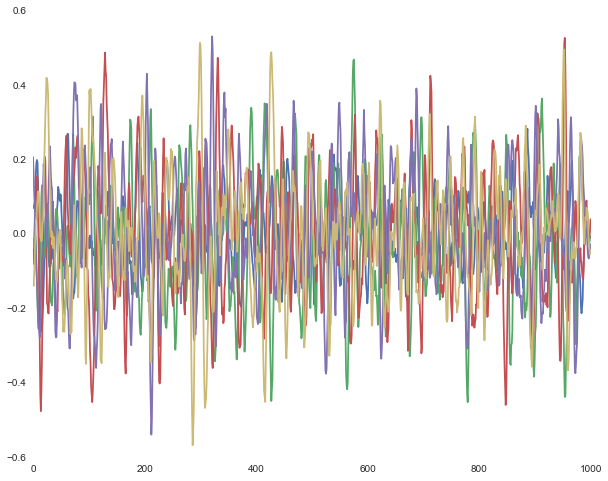

In [15]:
p = plot(inhibition[::10,:].T)

# Compute correlations between ganglion pairs

In [16]:
ganglion_corrs = np.zeros((len(ganglions), len(ganglions)))
for idg,g1 in enumerate(ganglions):
    for jdg,g2 in enumerate(ganglions):
        ganglion_corrs[idg,jdg] = pearsonr(g1,g2)[0]

<matplotlib.colorbar.Colorbar instance at 0x118ba70e0>

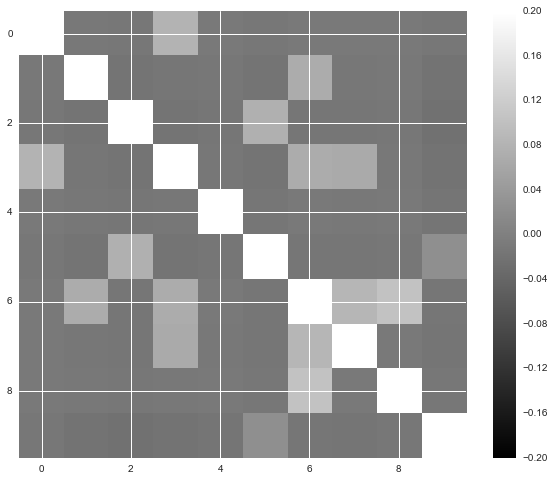

In [17]:
imgplot = imshow(ganglion_corrs)
imgplot.set_clim(-0.2,0.2)
colorbar()

In [18]:
np.diag(ganglion_corrs, k=-1)

array([-0.01108196, -0.01807365, -0.01807365, -0.01301445, -0.01544602,
       -0.01471976,  0.08575865, -0.00947082, -0.01377862])

In [19]:
inhibition, ganglions = ganglion_population_response(stimulus, threshold=.2, poisson_discount=1.,
                                                    num_ganglion_cells=500, every_n_ama=1)

/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:54: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [20]:
inhibition.shape

(500, 1000)

In [21]:
ganglions.shape

(500, 1000)

In [22]:
ganglion_corrs = np.zeros((len(ganglions), len(ganglions)))
for idg,g1 in enumerate(ganglions):
    for jdg,g2 in enumerate(ganglions):
        ganglion_corrs[idg,jdg] = pearsonr(g1,g2)[0]

<matplotlib.colorbar.Colorbar instance at 0x1143b9a70>

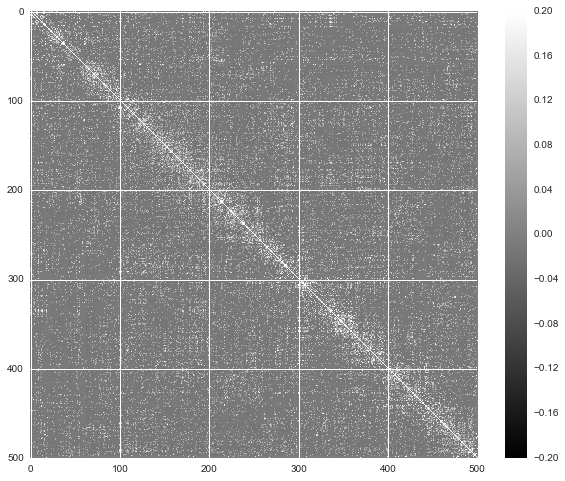

In [23]:
imgplot = imshow(ganglion_corrs)
imgplot.set_clim(-0.2,0.2)
colorbar()

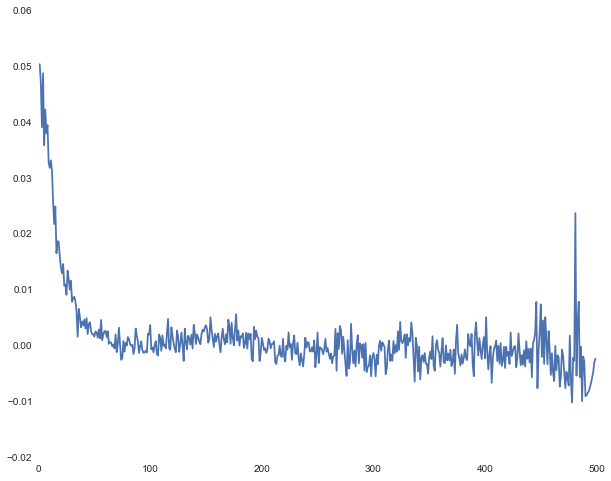

In [24]:
corr_fn_dist = [np.mean(np.diag(ganglion_corrs, k=d)) for d in -np.arange(1,len(ganglions))]
plot(np.arange(1,len(ganglions)), corr_fn_dist)

In [25]:
normalized_response = ganglions - np.mean(ganglions)
ganglion_corrs_straight = normalized_response.dot(normalized_response.T)/(ganglions.shape[1] * np.var(ganglions))

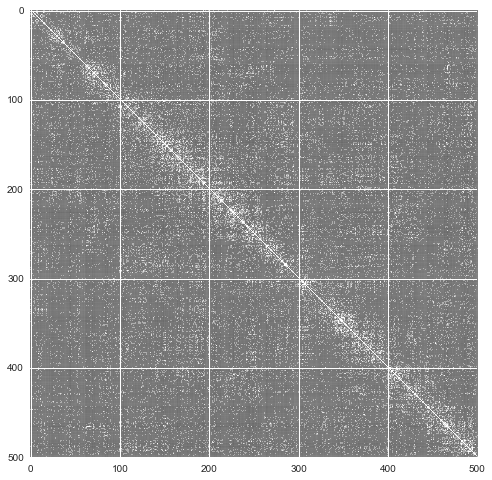

In [26]:
imgplot = imshow(ganglion_corrs_straight)
imgplot.set_clim([-0.2, 0.2])

In [27]:
(np.min(ganglion_corrs_straight), np.max(ganglion_corrs_straight))

(-0.039438684000631663, 2.1460519900944175)

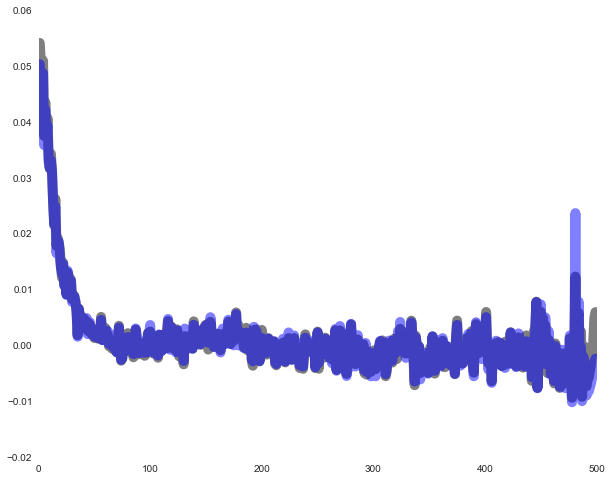

In [28]:
corr_fn_dist_dot = [np.mean(np.diag(ganglion_corrs_straight, k=d)) for d in -np.arange(1,len(ganglions))]
plot(np.arange(1,len(ganglions)), corr_fn_dist_dot, 'k', linewidth=10, alpha=0.5)
plot(np.arange(1,len(ganglions)), corr_fn_dist, 'b', linewidth=10, alpha=0.5)

# Compute correlations across space and time between ganglion-amacrine pairs

<matplotlib.colorbar.Colorbar instance at 0x118e92518>

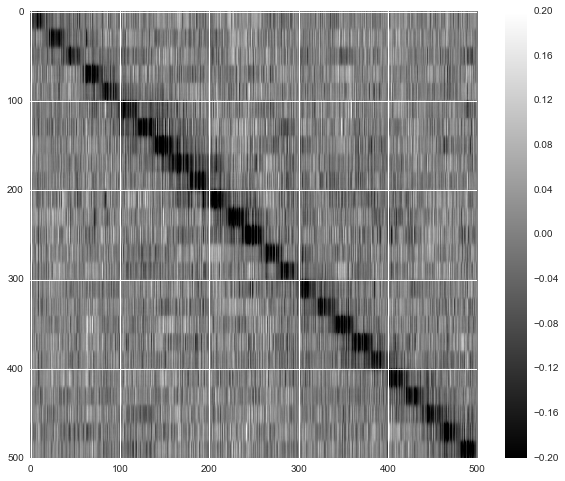

In [29]:
ganglion_inhibition_corrs = (inhibition - np.mean(inhibition)).dot(ganglions.T - np.mean(ganglions))
ganglion_inhibition_corrs /= ganglions.shape[1] * np.std(inhibition) * np.std(ganglions)
imgplot = imshow(ganglion_inhibition_corrs)
imgplot.set_clim([-.2, .2])
colorbar()

In [30]:
ganglion_inhibition_corr_fn_distance = [np.mean(np.diag(ganglion_inhibition_corrs, k=d)) for d in \
                                        -np.arange(1,len(ganglions))]

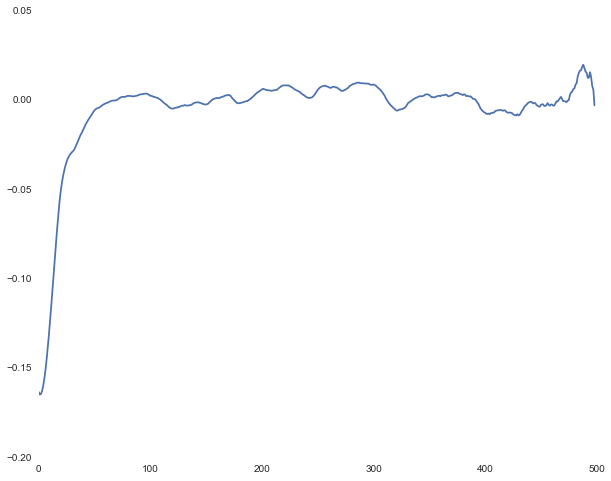

In [31]:
plot(ganglion_inhibition_corr_fn_distance)

#### Note how the correlation matrix has essentially 25 dimensions down the inhibition axis, corresponding to the 25 checkers

## Compare correlation between ganglion-ganglion pairs with amacrine-ganglion pairs

In [32]:
len(ganglion_inhibition_corr_fn_distance)

499

In [33]:
len(corr_fn_dist)

499

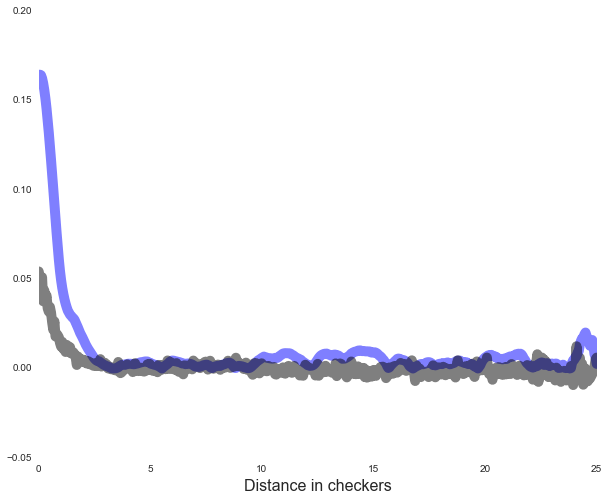

In [34]:
plot(np.linspace(0,len(ganglions)/pixels_per_checker, len(ganglions)-1), 
     [abs(x) for x in ganglion_inhibition_corr_fn_distance], 'b', linewidth=10, alpha=0.5)
plot(np.linspace(0,len(ganglions)/pixels_per_checker, len(ganglions)-1),
     corr_fn_dist_dot, 'k', linewidth=10, alpha=0.5)
xlabel('Distance in checkers', fontsize=16)

In [42]:
i_g_corrs = np.zeros((inhibition.shape[0], ganglions.shape[0]))
for idi in range(inhibition.shape[0]):
    for idg in range(ganglions.shape[0]):
        i_g_corrs[idi,idg] = pearsonr(inhibition[idi, :], ganglions[idg, :])[0]
        
i_g_corrs_dist = [np.mean(np.diag(ganglion_inhibition_corrs, k=d)) for d in \
                                        -np.arange(-len(ganglions),len(ganglions))]
        

/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


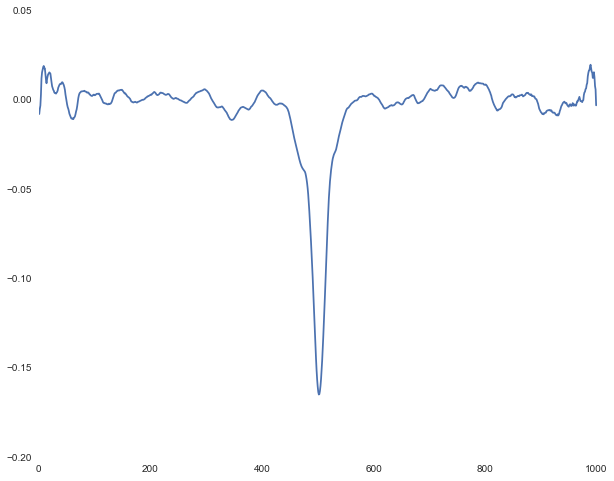

In [43]:
plot(i_g_corrs_dist)

# Correlations across time

In [44]:
def corr(x,y):
    result = np.correlate(x, y, mode='same')
    return result[result.size/2:]

In [45]:
def temporal_corr(x,y):
    return np.convolve(x,y[::-1],mode='same')

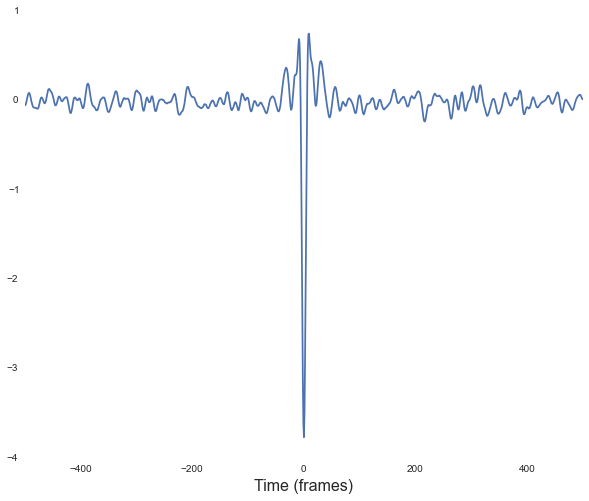

In [46]:
t_corr_all_cells = [temporal_corr(inhibition[c,:], ganglions[c,:]) for c in range(ganglions.shape[0])]
temporal_correlations_control = np.mean(np.vstack(t_corr_all_cells), axis=0)
plot(np.linspace(-500,500,1000), temporal_correlations_control)
x = xlim([-500,500])
xlabel('Time (frames)', fontsize=16)

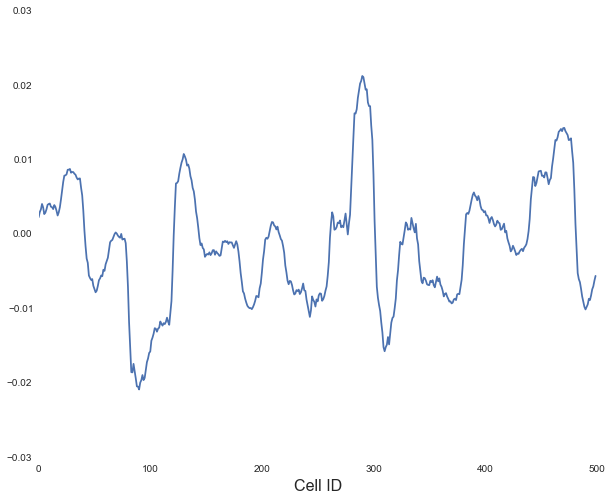

In [47]:
means = [np.mean(inhibition[c,:]) for c in range(inhibition.shape[0])]
plot(means)
xlabel('Cell ID', fontsize=16)

# Visualize space-time correlations

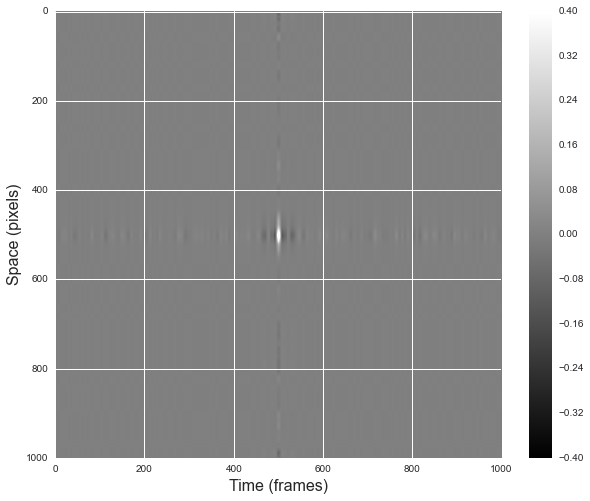

In [48]:
# assumes independence
space_time_corrs = np.outer(i_g_corrs_dist, temporal_correlations_control)
imgplot = imshow(space_time_corrs)
imgplot.set_clim([-0.4, 0.4])
colorbar()
xlabel('Time (frames)', fontsize=16)
ylabel('Space (pixels)', fontsize=16)

# Manipulate amacrine input to ganglion cells  

Amplifying the amacrine membrane potential (+1) is equivalent to setting the gain to 2. Diminishing the amacrine membrane potential (-1) is equivalent to setting the gain to 0.

In [49]:
# control
inhibition, ganglions = ganglion_population_response(stimulus, threshold=.2, poisson_discount=1.,
                                                    num_ganglion_cells=500, every_n_ama=1)
# amplify
inhibition_amplify, ganglions_amplify = ganglion_population_response(stimulus, threshold=.2, poisson_discount=1.,
                                                    num_ganglion_cells=500, every_n_ama=1, 
                                                    inhibitory_gain=2.)
# diminish
inhibition_diminish, ganglions_diminish = ganglion_population_response(stimulus, threshold=.2, poisson_discount=1.,
                                                    num_ganglion_cells=500, every_n_ama=1, 
                                                    inhibitory_gain=0.)

/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:54: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:54: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:54: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [50]:
all_inhibition = [inhibition, inhibition_amplify, inhibition_diminish]
all_ganglions = [ganglions, ganglions_amplify, ganglions_diminish]

# Perform desired analyses for each condition  
- Correlations across ganglion populations  
- Correlation across space & time for amacrine-ganglion pairs

In [51]:
distance_per_pixel = 0.027 # mm (actually, it's 0.022mm for bipolar cell and 0.027mm for amacrine cell)
time_per_frame = 0.01 # seconds, or 10 ms

In [52]:
def temporal_corr(x,y):
    return np.convolve(x,y[::-1],mode='same')

In [70]:
ganglion_population_correlations = []
ganglion_temporal_correlations = []
amacrine_ganglion_spatial_correlations = []
amacrine_ganglion_temporal_correlations = []
ganglion_firing_rates = []
for ama, rgc in zip(all_inhibition, all_ganglions):
    # compute spatial correlations of ganglion population
    corr_matrix = (rgc - np.mean(rgc)).dot(rgc.T - np.mean(rgc))
    corr_matrix /= rgc.shape[1] * np.var(rgc)
    spatial_ganglion_corrs = [np.mean(np.diag(corr_matrix, k=d)) for d in range(-rgc.shape[0], rgc.shape[0])]
    ganglion_population_correlations.append(spatial_ganglion_corrs)
    
    # compute spatial correlations of amacrine-ganglion pairs
    corr_matrix = (ama - np.mean(ama)).dot(rgc.T - np.mean(rgc))
    corr_matrix /= ama.shape[1] * np.std(ama) * np.std(rgc)
    spatial_ama_rgc_corrs = [np.mean(np.diag(corr_matrix, k=d)) for d in range(-ama.shape[0], rgc.shape[0])]
    amacrine_ganglion_spatial_correlations.append(spatial_ama_rgc_corrs)
    
    # compute temporal correlations of amacrine-ganglion pairs
    t_corr_ama_rgc = [temporal_corr(ama[c,:], rgc[c,:])/(ama.shape[1]*np.std(ama[c,:])*np.std(rgc[c,:])) for c in range(ganglions.shape[0])]
    temporal_correlations_ama_rgc = np.mean(np.vstack(t_corr_ama_rgc), axis=0)
    amacrine_ganglion_temporal_correlations.append(temporal_correlations_ama_rgc)
    
    # compute temporal correlations of amacrine-ganglion pairs
    t_corr_rgc = [temporal_corr(rgc[c,:], rgc[c,:])/(rgc.shape[1]*np.var(rgc[c,:])) for c in range(ganglions.shape[0])]
    temporal_correlations_rgc = np.mean(np.vstack(t_corr_rgc), axis=0)
    ganglion_temporal_correlations.append(temporal_correlations_rgc)
    
    # compute average firing rate for each cell
    firing_rates = np.sum(rgc, axis=1)/(time_per_frame * num_frames)
    ganglion_firing_rates.append(firing_rates)

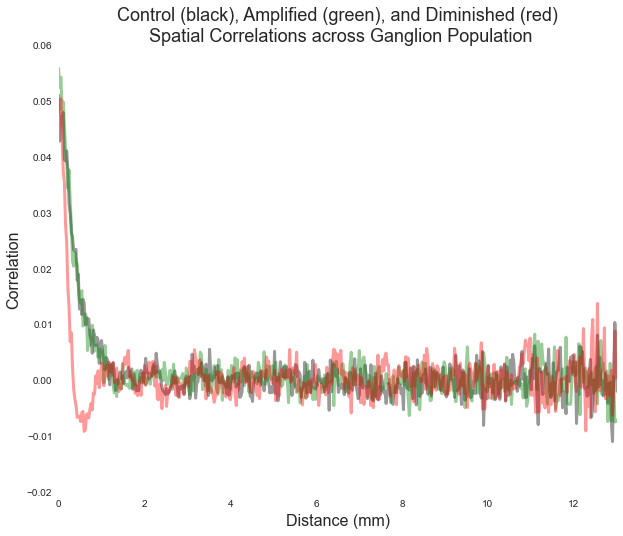

In [54]:
space = np.linspace(0, distance_per_pixel*(num_pixels-1), num_pixels-1)
plot(space, ganglion_population_correlations[0][501:], 'k', linewidth=3, alpha=0.4)
plot(space, ganglion_population_correlations[1][501:], 'g', linewidth=3, alpha=0.4)
plot(space, ganglion_population_correlations[2][501:], 'r', linewidth=3, alpha=0.4)
xlabel('Distance (mm)', fontsize=16)
ylabel('Correlation', fontsize=16)
title('Control (black), Amplified (green), and Diminished (red) \n Spatial Correlations across Ganglion Population',
      fontsize=18)
x = xlim([0,13])

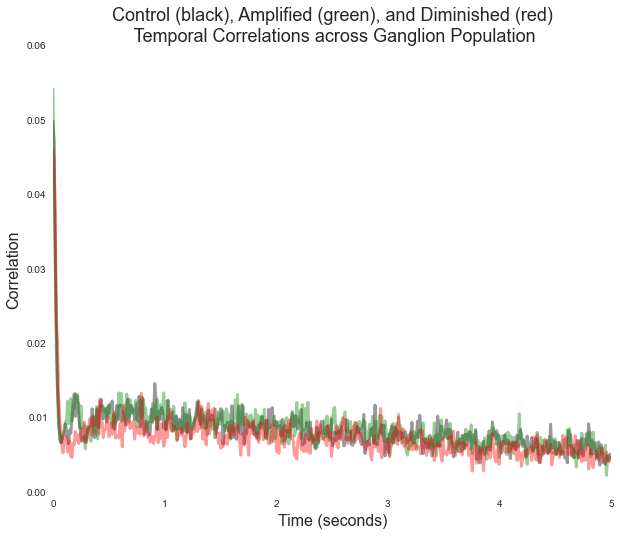

In [71]:
time = np.linspace(0, time_per_frame*(num_frames/2-1), num_frames/2-1)
plot(time, ganglion_temporal_correlations[0][501:], 'k', linewidth=3, alpha=0.4)
plot(time, ganglion_temporal_correlations[1][501:], 'g', linewidth=3, alpha=0.4)
plot(time, ganglion_temporal_correlations[2][501:], 'r', linewidth=3, alpha=0.4)
xlabel('Time (seconds)', fontsize=16)
ylabel('Correlation', fontsize=16)
title('Control (black), Amplified (green), and Diminished (red) \n Temporal Correlations across Ganglion Population',
      fontsize=18)

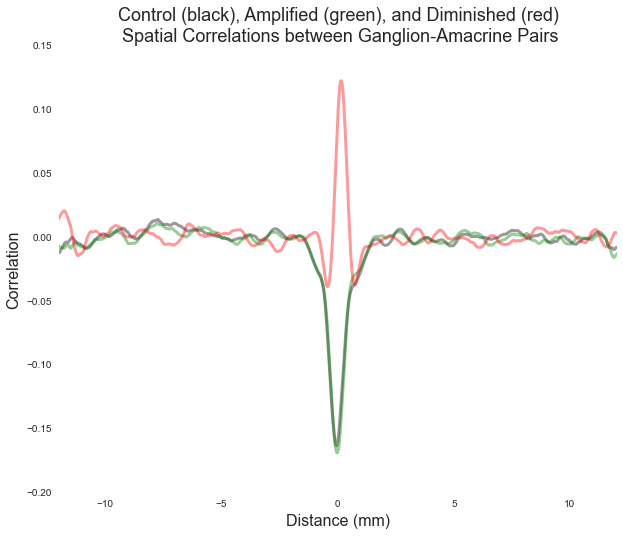

In [56]:
space = np.linspace(-distance_per_pixel*(num_pixels), distance_per_pixel*(num_pixels), 2*num_pixels)
plot(space, amacrine_ganglion_spatial_correlations[0], 'k', linewidth=3, alpha=0.4)
plot(space, amacrine_ganglion_spatial_correlations[1], 'g', linewidth=3, alpha=0.4)
plot(space, amacrine_ganglion_spatial_correlations[2], 'r', linewidth=3, alpha=0.4)
xlabel('Distance (mm)', fontsize=16)
ylabel('Correlation', fontsize=16)
title('Control (black), Amplified (green), and Diminished (red) \n Spatial Correlations between Ganglion-Amacrine Pairs',
      fontsize=18)
x = xlim([-12, 12])

In [69]:
time = np.linspace(-time_per_frame*num_frames/2, time_per_frame*num_frames/2, num_frames)
plot(time, amacrine_ganglion_temporal_correlations[0], 'k', linewidth=3, alpha=0.4)
plot(time, amacrine_ganglion_temporal_correlations[1], 'g', linewidth=3, alpha=0.4)
plot(time, amacrine_ganglion_temporal_correlations[2], 'r', linewidth=3, alpha=0.4)
xlabel('Time (seconds)', fontsize=16)
ylabel('Correlation', fontsize=16)
title('Control (black), Amplified (green), and Diminished (red) \n Temporal Correlations between Ganglion-Amacrine Pairs',
      fontsize=18)
x = xlim([-4,4])
mpld3.display()

#### Visualize firing rates across conditions

In [58]:
all_firing_rates = np.vstack(ganglion_firing_rates).T # cells by condition
control_firing = all_firing_rates[:,0]
relative_firing_rate_change = 100 * ((all_firing_rates.T - control_firing)/control_firing).T

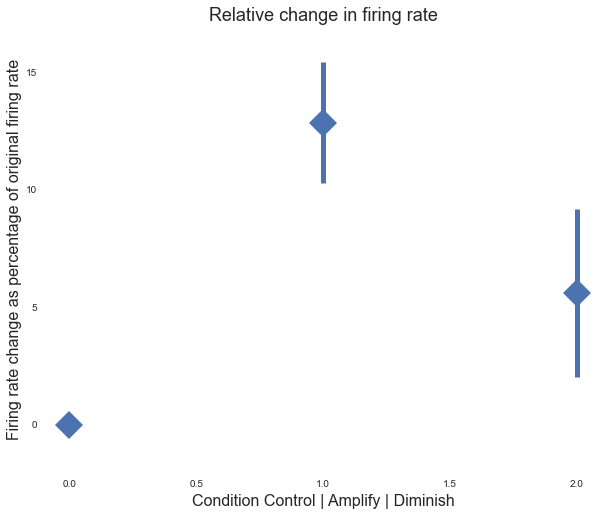

In [63]:
average_firing_rate_change = np.mean(relative_firing_rate_change, axis=0)
errorbar([0,1,2], average_firing_rate_change, yerr=sem(relative_firing_rate_change), fmt='D', markersize=20, linewidth=5)
x = xlim([-0.1, 2.1])
y = ylim([-2, 17])
xlabel('Condition Control | Amplify | Diminish', fontsize=16)
ylabel('Firing rate change as percentage of original firing rate', fontsize=16)
title('Relative change in firing rate', fontsize=18)

### Amacrine-Ganglion correlations are positive in experimental data; could offset amacrine cells so that we're appropriately aligned.  

### Alternatively, could do temporal correlation in experiment to align the amacrine-ganglion pairs in the large negative phase of its transmission filter.

Don't need to compare inhibition across trials because I'm just changing the inhibitory transmission, not actually effecting its membrane potential

/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:54: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


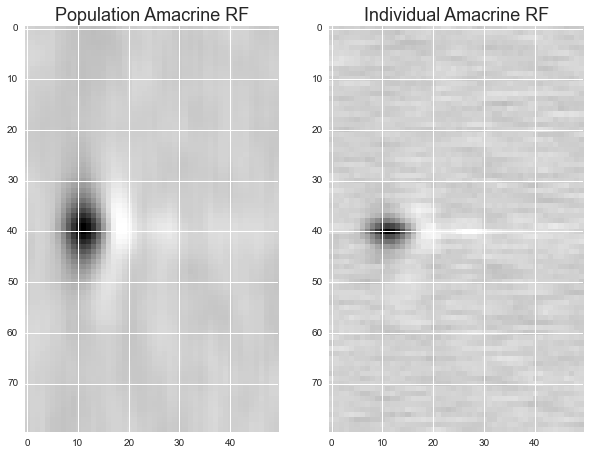

In [60]:
inh,gang = ganglion_population_response(stimulus, plot_amacrine_rfs=True, plot_bipolar_rfs=False)

/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:54: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


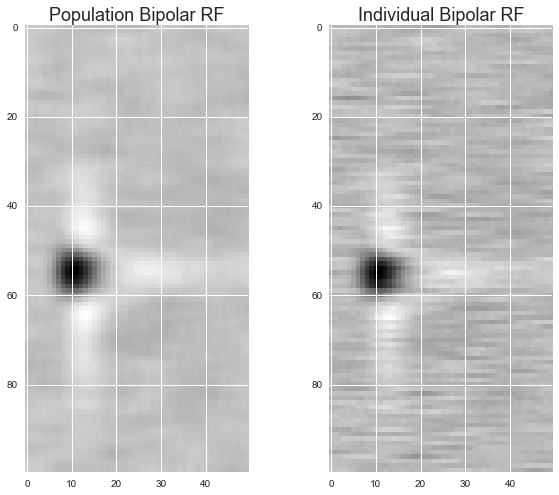

In [61]:
inh,gang = ganglion_population_response(stimulus, plot_amacrine_rfs=False, plot_bipolar_rfs=True)

# What is the time offset where we get positive correlations?

In [75]:
index_of_max_corr = np.argmax(amacrine_ganglion_temporal_correlations[1])

In [76]:
amacrine_ganglion_temporal_correlations[1][index_of_max_corr]

0.035041092640609575

In [84]:
time_delay_of_max_positive_corr = (index_of_max_corr - 500) * time_per_frame
print '%f seconds' %(time_delay_of_max_positive_corr)

0.090000 seconds
